## Implement Text Similarity using Word Embeddings of Glove + Cosine Similarity

In [22]:
text1 = "President greets the press in Chicago"
text2 = "Obama speaks to media Illinois"

In [23]:
#importing necessary packages
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
#nltk.download("stopwords")

#pre-trained word embedding Glove Model
embedding_path = r"D:\Study_notebooks\NLP\pretrained_models\glove.6B\glove.6B.50d.txt"

In [24]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

def remove_stop_words(tokens):
    stopwords = nltk.corpus.stopwords.words("english")
    tokens_without_stopwords = [word.lower() for word in tokens if word not in stopwords]
    return tokens_without_stopwords

In [25]:
text1_tokens = remove_stop_words(tokenize_text(text1))
text2_tokens = remove_stop_words(tokenize_text(text2))



In [26]:
text1_tokens

['president', 'greets', 'press', 'chicago']

In [27]:
text2_tokens

['obama', 'speaks', 'media', 'illinois']

In [28]:
def load_glove_embeddings(embeddings_path):
    embeddings_index = {}
    with open(embeddings_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefficients = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefficients
    return embeddings_index

We can load the glove embeddings using above function. where in each line we have first word (values[0]) as the word following by it's embedding vector

In [8]:
word_embeddings = load_glove_embeddings(embedding_path)

#testing the function
word = 'insanely'
embedding_vector = word_embeddings.get(word)
if embedding_vector is not None:
    # Word vector exists in the embeddings
    print(f"Word vector for '{word}': {embedding_vector}")
else:
    # Word vector doesn't exist in the embeddings
    print(f"No word vector found for '{word}'")

Word vector for 'insanely': [ 0.32575  -0.7108   -0.14064  -0.55279  -0.54043   0.10792   0.80933
  0.13154  -0.51524   1.4908   -0.69343   0.48552  -0.11583   0.18464
 -0.2386   -0.24543   0.4658    1.5631    0.74832  -0.19505  -0.54348
 -0.037962 -0.22807   1.0095    1.2854   -0.42222  -0.44433   0.63587
  0.66522   0.3367    0.20846  -0.12542   1.4839    0.74024  -0.081622
  0.045189 -0.35995   0.66447  -1.2046   -0.55015  -0.10035   0.088914
 -0.43324   0.82637   0.6313   -0.10488  -0.30551  -0.606     0.27067
  0.56091 ]


In [29]:
#Let's now find the embedding for the two above sentences by averaging the vectors of each word present in sentence(after preprocessing)

def find_sentence_vector(vectors_list):
    vector = np.mean(vectors_list,axis=0)
    return vector
    
def create_list_of_vectors(tokens):
    vectors_list = []
   
    for token in tokens:
        embedding_vector = word_embeddings.get(token)
        if embedding_vector is not None:
            # Word vector exists in the embeddings
            vectors_list.append(embedding_vector)

        else:
            # Word vector doesn't exist in the embeddings
            print(f"No word vector found for '{token}'")
    return vectors_list
    

In [30]:
sent_vector_1 = find_sentence_vector(create_list_of_vectors(text1_tokens))
sent_vector_2 = find_sentence_vector(create_list_of_vectors(text2_tokens))

In [31]:
#Calculate the cosine similarity of the two sentences
def calculate_cosine_similarity(embedding1, embedding2):
    if embedding1 is not None and embedding2 is not None:
        similarity = cosine_similarity([embedding1], [embedding2])[0][0]
        return similarity
    else:
        return None

In [32]:
cos_sim = calculate_cosine_similarity(sent_vector_1, sent_vector_2)
cos_sim # Since the value is close to one the sentences are mostly similar

0.8124777

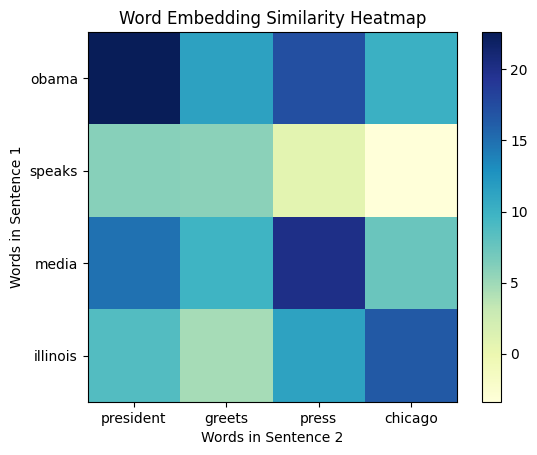

In [36]:
#similarity matrix to draw heatmap to see word level similarity
word_embeddings_1 = np.array(create_list_of_vectors(text1_tokens))
word_embeddings_2 = np.array(create_list_of_vectors(text2_tokens))

similarity_matrix = np.dot(word_embeddings_1,word_embeddings_2.T)
plt.imshow(similarity_matrix, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.xlabel("Words in Sentence 2")
plt.ylabel("Words in Sentence 1")
plt.xticks(range(len(text1_tokens)), text1_tokens)
plt.yticks(range(len(text2_tokens)), text2_tokens)
plt.title("Word Embedding Similarity Heatmap")
plt.show()


# Smooth Inverse Frequency

**Instead of taking average of the word embeddings in the sentence, which gives equal weightage to every word, WHat we can do instead is do a weighted average by discounting the weightts of word that occur too frquently in the corpus and hence giving more importance to words that are rare.** <br>

**Every word embedding is weighted by a/(a + p(w)), where a is a parameter that is typically set to 0.001 and p(w) is the estimated frequency of the word in a reference corpus.** <br>

**Common component removal: SIF computes the principal component of the resulting embeddings for a set of sentences. It then subtracts from these sentence embeddings their projections on their first principal component. This should remove variation related to frequency and syntax that is less relevant semantically.**

# Latent Semantic Indexing

## Implementing Latent Semantic indexing

In [116]:
#let's consider 3 documents and one query. We will try to find the document which is most relevant to query.

d1 = "I got gold earrings"
d2 = "Delivery of gold arrived in a silver truck"
d3 = "I like silver more than gold rings"

q = "gold silver truck"

In [117]:
#createing a Term-Document matrix
from sklearn.feature_extraction.text import CountVectorizer

corpus = [d1,d2,d3]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
term_doc_matrix = X.toarray().T
print(term_doc_matrix)

[[0 1 0]
 [0 1 0]
 [1 0 0]
 [1 1 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 1]
 [0 0 1]
 [0 1 0]]


In [118]:
#Doing SVD Decomposition of term_doc_matrix

U, s, VT = np.linalg.svd(term_doc_matrix)

print("Term - Conept Matrix", U, end = "\n\n")
print("Concept Weightage Matrix", s, end = "\n\n")
print("Document Concept Matrix", VT, end = "\n\n")

Term - Conept Matrix [[-0.25520074  0.30166884  0.07598194 -0.6847778  -0.45345231 -0.08104173
  -0.15028376 -0.15028376 -0.08104173 -0.15028376 -0.23132549 -0.15028376
  -0.08104173]
 [-0.25520074  0.30166884  0.07598194  0.08751417  0.32094476 -0.42112142
   0.18769082  0.18769082 -0.42112142  0.18769082 -0.23343059  0.18769082
  -0.42112142]
 [-0.07772591 -0.04215812 -0.59505137 -0.13367363 -0.41725238 -0.01837221
   0.30195096  0.30195096 -0.01837221  0.30195096  0.28357875  0.30195096
  -0.01837221]
 [-0.53600387 -0.10345136 -0.3868032   0.5317523  -0.23427055 -0.03649501
  -0.19748214 -0.19748214 -0.03649501 -0.19748214 -0.23397715 -0.19748214
  -0.03649501]
 [-0.07772591 -0.04215812 -0.59505137 -0.39807867  0.65152293  0.05486722
  -0.10446882 -0.10446882  0.05486722 -0.10446882 -0.04960159 -0.10446882
   0.05486722]
 [-0.25520074  0.30166884  0.07598194  0.04522679  0.08419052  0.87667346
   0.0843628   0.0843628  -0.12332654  0.0843628  -0.03896373  0.0843628
  -0.12332654]
 [

#### By doing Rank-2 Approximation, we can discard the less important weightage, i.e. last vector. Let's discard:<br>
    1. 3rd Column of U 
    2. 3rd Singular Value of s 
    3. 3rd Row of VT

In [119]:
d1_concept_vector, d2_concept_vector,d3_concept_vector = VT[0], VT[1], VT[2]


In [120]:
#cONSIDERING ONLY FIRST THREE eIGEN Vectors
U = [each[:3] for each in U]


In [121]:
q_vector = vectorizer.transform([q]).toarray()

In [122]:
q_vector

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]], dtype=int64)

In [123]:
#To take inverse, we are transposing ,atrix here as both are essentially the same for Orthogonal Matrix
q_vector_weight = np.matmul(q_vector,U)

In [124]:
q_vector_weight.shape

(1, 3)

In [125]:
s_transpose = np.diag(s).T
s_transpose.shape

(3, 3)

In [126]:
q_vector_weight = np.matmul(q_vector_weight,s_transpose)                         

In [127]:
q_vector_weight

array([[-3.72674332,  0.28896822, -0.16697793]])

In [128]:
#Now, let's calculate cosine similarity for each document
cos_sim = [calculate_cosine_similarity(q_vector_weight[0],each) for each in VT]
print(cos_sim)

[0.19914900372638975, 0.17196953318557615, 0.9647622266500288]
